In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Dict, Optional, Any
from pydantic import BaseModel, Field
import operator
from pytrends.request import TrendReq
from langchain_community.tools.tavily_search import TavilySearchResults
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
import os
import requests
from datetime import datetime

In [4]:
load_dotenv()

True

In [5]:
model = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash'
)

In [6]:
class EvaluationSchema(BaseModel):

    Feedback: str=Field(description="Detailed feedback for the content for linkedin")
    Score: str = Field(description = "Score out of 10", ge=0, le=10)

class LinkedInSchema(BaseModel):
    
    post_text : str = Field(description="The full text of the linkedin post formatted with hooks, emojis and hashtags.")    

class LearnedPreferences(BaseModel):
    """Schema for the AI's learned preferences."""
    preferences: str = Field(description="A 1-2 sentence summary of new content strategies based on engagement data. For example: 'Posts about practical code seem to perform well.'")

In [131]:
structured_llm = model.with_structured_output(EvaluationSchema)

In [132]:
class PostDraft(TypedDict):

    """A single object that holds all the data for one LinkedIN post"""
    # Node 1 & 2
    original_topic : Dict[str, Any] # Dict[str, Any]: gives you the flexibility to handle this real-world, messy data while still having some type safety (you know the keys are strings).
    draft_text : str

    # Node 3
    fact_check: Optional[EvaluationSchema]
    quality_check: Optional[EvaluationSchema]
    engagement_check: Optional[EvaluationSchema]

    # Node 4 : final evaluation
    final_score : Optional[int]
    final_feedback : Optional[str]

    # Node 6 :Optimizer
    revision_count : int

class Published_post(TypedDict):

    post_id : str
    url : str
    published_at : str
    content_text : str

In [ ]:
class AutoInfluenceState(TypedDict):

    """The main state for autonomus LinkedIn agent"""

    # Node 8 (feedback) -> Node 1(Trend_analyzer)
    learned_preferances : Optional[str]

    # Node 1 -> Node 2(content generator)
    trending_topics : List[Dict[str, Any]]

    # This will contain LinkedIn drafts
    current_drafts : List[PostDraft]

    # Node 5(publisher) creates this 
    newly_published : List[Published_post]

    # Node 7(memory) adds this to master log 
    master_log_published : Annotated[List[Published_post], operator.add]

    run_complete: bool

    drafts_to_publish: List[PostDraft]
    drafts_to_optimize: List[PostDraft]

In [134]:
# def node_name(state: AutoInfluenceState):
#     # read from state
#     # do something (API call, LLM, computation)
#     # return a partial dict of updates

In [135]:
def scheduler_gate(state: AutoInfluenceState):

    if state.get("run_complete"):
        return "END"
    else: 
        return "trend_analyzer"

In [136]:
# Schema for trend analyzer
class TrendingTopics(BaseModel):

    topics : List[Dict[str, Any]] = Field(description="A list of trending topics each with topic name, score and source.")

In [137]:
def trend_analyzer(state: AutoInfluenceState):

    """Analyzes the trending topics for autonomus agent:
        # Reads memory
        # Fetch fresh trends
        # combines both (learned + global trends)
        # Choose final topics (5)
    """

    llm = ChatGoogleGenerativeAI(
        model = "gemini-2.5-flash"
    )

    # Tools to get the trends
    search_tool = TavilySearchResults(max_results = 3)
    pytrends = TrendReq(hl = "en-US", tz=360)

    preferences = state.get("learned_preferances", "general AI and tech topics")
    
    all_search_results = ""

    try:
        trends = pytrends.trending_searches(pn="india")
        all_search_results += f"Google trends {trends.head(5).to_string()}"
        print("trends data successfully fetched...")

    except Exception as e:
        print("Google trends api failed: {e}")
        all_search_results += f"Google trends data unavailable.\n"

    # Use LLM to generate search queries
    query_gen_prompt = ChatPromptTemplate.from_template(
        "You are a social media trend analyst. Your user is a LinkedIn influencer focused on {persona}"
        "Based on these learned preferences {preferences}"
        "generate 3-5 keywords to search for the latest, most interesting topics"
    )

    query_gen_chain = query_gen_prompt | llm
    query_response = query_gen_chain.invoke({
        "persona" : "AI and Generative AI",
        "preferences" : preferences
    })

    search_queries = query_response.content.strip().split("\n")
    print(f"Generated search queries : {search_queries}")

    # Execute the tavily search for each query
    for query in search_queries:
        if query:
            results = search_tool.invoke(query)
            all_search_results += f"Query : {query} \n results : {results} \n\n"

    # Synthesise all the results into topics 
    synthesis_prompt = ChatPromptTemplate.from_template(
        "You are a LinkedIn content strategist. You must find the best topics for the user." 
        "Their persona is {persona}"
        "Their learned preferences are {preferences}"
        "I have raw data from googele trends and tavily search : \n ----RESULTS--- \n{all_search_results}\n ----END RESULTS--- \n"
        "Synthesise these results into final 3 high potential, specific and interesting topics."
        "Priotize topics that are both broadly trending (from google) and relevant to niche(Tavily)"
        "Format your output as a json object matching the 'TrendingTopics' schema" 
    )
    
    structured_topic_llm = llm.with_structured_output(TrendingTopics)

    synthesis_chain = synthesis_prompt | structured_topic_llm

    final_topics = synthesis_chain.invoke({
        "persona" : "AI and Generative AI",
        "preferences" : preferences,
        "all_search_results" : all_search_results
    })

    print(f"Synthesised {len(final_topics.topics)} topics")

    return {"trending_topics" : final_topics.topics}


In [138]:
def content_generator(state: AutoInfluenceState):

    """Generates a draft linkedIn post"""

    print("-----------Generating content---------\n")

    topics = state.get("trending_topics", [])

    if not topics:
        print("No topics for content generation")
        return {}
    
    generation_prompt = ChatPromptTemplate.from_template(
        """
        You are an expert LinkedIn Influencer(Persona{persona})
        Your writing style is Insightful, professional and engaging.
        You always write by factual information not by hallucination.
        Based on this topic: '{topic_name}' (Source: {source}, Score: {score})
        Write a complete LinkedIn post.
        Follow all the instructions and output in the 'LinkenInPost' schema.
        """
    )

    structured_llm = model.with_structured_output(LinkedInSchema)
    generation_chain = generation_prompt | structured_llm
    new_drafts = []

    # Loop through all topics 
    for topic in topics:

        response: LinkedInSchema = generation_chain.invoke({
                "persona": "AI and Generative AI",
                "topic_name": topic.get("topic"),
                "topic_source": topic.get("source"),
                "topic_score": topic.get("score")
            })
        

        draft = PostDraft(
            
            original_topic = topic,
            draft_text = response.post_text,
            fact_check = None,
            quality_check = None,
            engagement_check = None,
            final_score = None,
            
            final_feedback = None,
            revision_count = 0
        )

        new_drafts.append(draft)
        print(f"Successfull generated draft for topic: {topic.get("topic")}\n")

    
    print(f"Total drafts created: {len(new_drafts)}")
    
    return {
        "current_drafts" : new_drafts
    }

In [139]:
def fact_checker(state: AutoInfluenceState):
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are a expert fact checker. Analyze the following post.
        Check if All the claims, statics and statements verifiable and accurate?
        Give a score of 0(total hallucination) and 10(perfectly accurate)
        Provide feedback on what to fix.
        Post:
        {draft_text}

        Return your analysis in the 'EvaluationSchema' JSON format.
        """
        )
    
    
    fact_check_chain = prompt | model.with_structured_output(EvaluationSchema)

    for draft in state["current_drafts"]:

        try:
            response = fact_check_chain.invoke({
                "draft_text" : draft["draft_text"]
            })
            # modified state
            draft["fact_check"] = response     

        except Exception as e:
            print(f"Error in fact checker {e}")
            draft["fact_check"] = EvaluationSchema(feedback="Error in fact checker", score=0)
            

    return {}

In [141]:
def engagement_checker(state: AutoInfluenceState):
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are LinkedIn growth hacker. Analyze the post for virality.
        Does it have a strong hook? Is it easy to read(good formatting)?
        Does it have clear Call-To-Action(CTA) like a question?
        Give a score from 0(boring) to 10(viral potential).
        Provide brief feedback

        POST: 
        {draft_text}

        Return your analysis in the 'EvaluationSchema' JSON format.
        """)
    
    engagement_check_chain = prompt | model.with_structured_output(EvaluationSchema)

    for draft in state['current_drafts']:
        try:
            response = engagement_check_chain.invoke({
                "draft_text" : draft["draft_text"]
            })
            draft["engagement_check"] = response

        except Exception as e:
            print(f"Error in engagement checker {e}")
            draft["engagement_check"] = EvaluationSchema(Feedback="Error in engagement checker", Score= 0)

    return {}

In [ ]:
def quality_checker(state: AutoInfluenceState):
    

    preferences = state.get("learned_preferances", "General AI and Tech topics")

    prompt = ChatPromptTemplate.from_template(
        """
        You are a brand manager and editor. Analyze this post for quality.
        Does this match the user's style? (User's style: {preferences}).
        Is the tone professional and Insightfull. Is it well written?
        Give a score of 0(off-brand, low-quality) and 10(perfectly on-brand).
        Provide brief feedback.

        POST: 
        {draft_text}

        Return your analysis in the 'EvaluationSchema' JSON format.
        """)
    
    quality_check_chain = prompt | model.with_structured_output(EvaluationSchema)

    for draft in state['current_drafts']:
        try:
            response = quality_check_chain.invoke({
                "draft_text" : draft["draft_text"],
                "preferences" : preferences
            })
            draft["quality_check"] = response

        except Exception as e:
            print(f"Error in quality checker {e}")
            draft["quality_check"] = EvaluationSchema(Feedback="Error in quality checker", Score= 0)

    return {}

In [ ]:

def final_evaluator(state: AutoInfluenceState):
    
    current_drafts = state.get("current_drafts", [])

    if not current_drafts:
        return {}
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are the Editor-in-chief, you have specialist reports from your specialist editors:

        1. Fact Check Report : {fact_feedback}
        2. Quality Check Report : {quality_feedback}
        3. Engagement Check Report : {engagement_feedback}

        The post's final calculated average is: {final_score}/10

        Your job is to synthesize all their feedback into single, final, actionable instruction for the writer.
        If the score is high (>= 8), keep it brief (e.g., "Looks great, ready to publish.").
        If the score is low (< 8), be specific about what to fix first, combining the feedback.
        
        Return your feedback in the 'FinalEvaluation' JSON schema.
        """
    )

    synthesis_chain = prompt | model.with_structured_output(EvaluationSchema)

    for draft in current_drafts:

        scores = []
        feedbacks = []

        fact_check = draft.get("fact_check") or EvaluationSchema(feedback="N/A", score=0)
        engagement_check = draft.get("engagement_check") or EvaluationSchema(feedback="N/A", score=0)
        quality_check = draft.get("quality_check") or EvaluationSchema(feedback="N/A", score=0)

        scores = [fact_check['score'], quality_check['score'], engagement_check['score']]
        feedbacks = [
            f"Fact check: {fact_check['feedback']}",
            f"Quality check: {quality_check['feedback']}",
            f"Engagement Check: {engagement_check['feedback']}"
        ]

        final_score = round(sum(scores)/len(scores)) if scores else 0
        # It takes all three feedback items and joins them together into one readable string, separated by \n 
        feedback_reports = "\n".join(feedbacks)

        try:
            response = synthesis_chain.invoke({
                "fact_feedback" : fact_check["feedback"],
                "engagement_feedback" : fact_check["feedback"],
                "quality_feedback" : fact_check["feedback"],
                "final_score" : final_score
            })

            final_feedback = response.final_feedback

        except Exception as e:
            print(f"Error in final evaluation")
            final_feedback = "error in synthesis" + feedback_reports

        # Update the draft
        draft['final_score'] = final_score
        draft["final_feedback"] = final_feedback

        return {
            "current_drafts" : current_drafts
        }

In [ ]:
def filter_drafts(state: AutoInfluenceState):

    draft_to_publish = []
    draft_to_optimize = []

    drafts = state.get("current_drafts", [])

    if not drafts:
        print(f"No drafts to. filter")
        return "fail"
    
    for draft in drafts:
        score = draft.get("final_score", 0)
        revisions = draft.get("revision_count", 0)

        if score >= 8:
            draft_to_publish.append(draft)

        elif revisions < 3: 
            draft_to_optimize.append(draft)

        else:
            print("Failed max revisions")

    # Update the state with new list 
    state["draft_to_publish"] = draft_to_publish
    state["draft_to_optimize"] = draft_to_optimize

    return "split"

In [ ]:
def optimizer(state: AutoInfluenceState):
    
    prompt = ChatPromptTemplate.from_template(
        """
        You are an expert content writer. Yor editor has reviewed yout first draft and provided feedback.
        Your job is to rewrite the post to address all the feedback points.
        You will recieve:
            1. ORIGINAL POST of the linkedIn post
            2.  EDITORIAL FEEDBACK from a senior editor
         
        ORIGINAL POST: 
        {draft_text}

        EDITORIAL FEEDBACK:
        {final_feedback}

        Rewrite the post and return it in the 'LinkedInSchema' JSON schema.
        Make sure that new 'post_text' is improved based on feedback.

        """
    )


    optimization_chain = prompt | model.with_structured_output(LinkedInSchema)

    draft_to_optimize = state.get("drafts_to_optimize", [])

    fixed_drafts = []

    if not draft_to_optimize:

        return {"current_drafts" : []}
    
    for draft in draft_to_optimize:

        try:
            # Get the feedback
            feedback = draft.get("final_feedback", "No feedback provided")

            # Call the llm and rewrite
            response: LinkedInSchema = optimization_chain.invoke({
                "draft_text" : draft["draft_text"],
                "final_feedback" : feedback
            })


            ## Updating the draft objects 

            # Replace the draft_text state
            draft["draft_text"] = response.post_text

            draft["revision_count"] += 1

            # Reset all the evaouators to None so that it can re-evaluate
            draft["fact_check"] = None
            draft["quality_check"] = None
            draft["engagement_check"] = None
            draft["final_score"] = None
            draft['final_feedback'] = None

            # Add the fixerd draft to the list
            fixed_drafts.append(draft)

        
        except Exception as e:
            
            print(f"Error in optimizer node {e}")
            draft["revision_count"] += 1
            fixed_drafts.append(draft)

    
    # Return the fixed_draft list to 'current_drats' key.... so that they can be sent back to checkers
    return {"current_drafts" : fixed_drafts}

In [ ]:
LINKEDIN_ACCESS_TOKEN = os.environ.get("LINKEDIN_ACCESS_TOKEN")
LINKEDIN_PERSON_URN = os.environ.get("LINKEDIN_PERSON_URN")

def publisher(state: AutoInfluenceState):
    
    drafts_to_publish = state.get("drafts_to_publish", [])

    if not drafts_to_publish:
        print("    > No drafts to publish.")
        return {"newly_published": []}

    published_posts_log: List[Published_post] = []
    
    author_urn = f"urn:li:person:{LINKEDIN_PERSON_URN }"

    headers = {
        "Authorization" : f"Bearer {LINKEDIN_ACCESS_TOKEN}",
        "Content-type" : "application/json",
        "X-Restli-Protocol-Version" : "2.0.0",
        "LinkedIn-Version" : "202402"
    }

    url = "https://api.linkedin.com/v2/ugcPosts"

    for draft in drafts_to_publish:

        post_body = {
            "author": author_urn,  #user URN (who’s posting)
            "lifecycleState": "PUBLISHED",  # post goes live immediately

            "specificContent": {
                "com.linkedin.ugc.ShareContent": {
                    "shareCommentary": {
                        "text": draft['draft_text']  # main text of post
                    },
                    "shareMediaCategory": "NONE"  # text-only post
                }
            },

            "visibility": {
                "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"  # visible to everyone
            }
        }

        try:
            response = requests.post(url, headers=headers, data=JSON.dumps(post_body))

            if response.status_code == 201: # created
                response_data = response.json()
                post_id = response_data.get("id")
                
                print(f"Success...Post published. ID:{post_id}")

                new_log_entry = Published_post(
                    post_id=post_id,
                    url =f"https://www.linkedin.com/feed/update/{post_id}/",
                    published_at = datetime.now().isoformat(),
                    content_text=draft["draft_text"]
                )
                # Append the new wntry in the existing log
                published_posts_log.append(new_log_entry)

            else:
                print(f"FAILURE...status: {response.status_code} : {response.text}")
            
        except Exception as e:
            print(f"Exception during publish: {e}")

    
    return {"newly_published": published_posts_log}
            

In [ ]:
def memory_logger(state: AutoInfluenceState):
    new_posts = state.get("master_log_published")

    if new_posts:
        return {"master_log_published" : new_posts}
    
    return {}

In [ ]:
def feedback_updater(state: AutoInfluenceState):

    recent_posts = state.get("master_log_published",[])[:5]

    if not recent_posts:

        print("No published post to analyze...")
        return {
                "learned_preferences" : "General AI Topics",
                "run_complete" : True
            }

    LINKEDIN_ACCESS_TOKEN = os.environ.get("LINKEDIN_ACCESS_TOKEN")

    engagement_reports = []

    headers = {
        "Authorization" : f"Beared {LINKEDIN_ACCESS_TOKEN}",
        "X-Restli-Protocol-Version": "2.0.0"
    }

    for post in recent_posts:
        post_urn = post["post_id"]

        url = f"https://api.linkedin.com/v2/socialActions/{post_urn}"

        try: 
            response = requests.get(url, headers=headers)
            data = response.json()

            likes = data.get("likesSummary", {}).get("totalLikes", 0)
            comments = data.get("commentSummary", {}).get("totalFirslLevelComments", 0)
            views = data.get("viewContext", {}).get("views", 0)

            engagement_summary = engagement_reports.append(
                f"Post: \{post['content_text'][:80]}..\\n"
                f"Likes: {likes} | Comments : {comments} | Views: {views}"
            )
            print(f"Engagement fetched for: {post_urn} ")
        
        except Exception as e:
            print(f"Error fetching engagement for {post_urn} : {e}")

    if not engagement_reports:
        
        print(f"No engagement data fetched.")
        return {"run_complete" : True}
        
    engagement_summary = "\n----\n".join(engagement_reports)

    # Synthesisizing new preferences
    feedback_prompt = ChatPromptTemplate.from_template(
        """
        You are a LinkedIn growth strategist. Analyze these recent post metrics and return one 
        short actionable preference (e.g., “More posts about LangGraph
        perform well”, “Shorter posts get more engagement”, etc.)

        Metrics:
        {engagement_summary}

        Return only in json format in the 'LearnedPreferences' Schema.
        """
    )

    feedback_chain = feedback_prompt | model.with_structured_output(LearnedPreferences)

    try: 
        response = feedback_chain.invoke({
            "engagement_summary" : engagement_summary
        })

        learned_preferences = response.preferences
        print(f"Learned Preferences: {learned_preferences}")

        return {
            "learned_preferences" : learned_preferences,
            "run_complete" : True
        }
    
    except Exception as e:
        print(f"LLm syntesis failed: {e}")
        return {"run_complete" : True}

In [ ]:
def join_for_feedback(state: AutoInfluenceState):

    """Join for feedback"""

    print("Joining branches...")
    return {}

In [96]:
state = {}  # or whatever state you loaded from file
state["run_complete"] = False

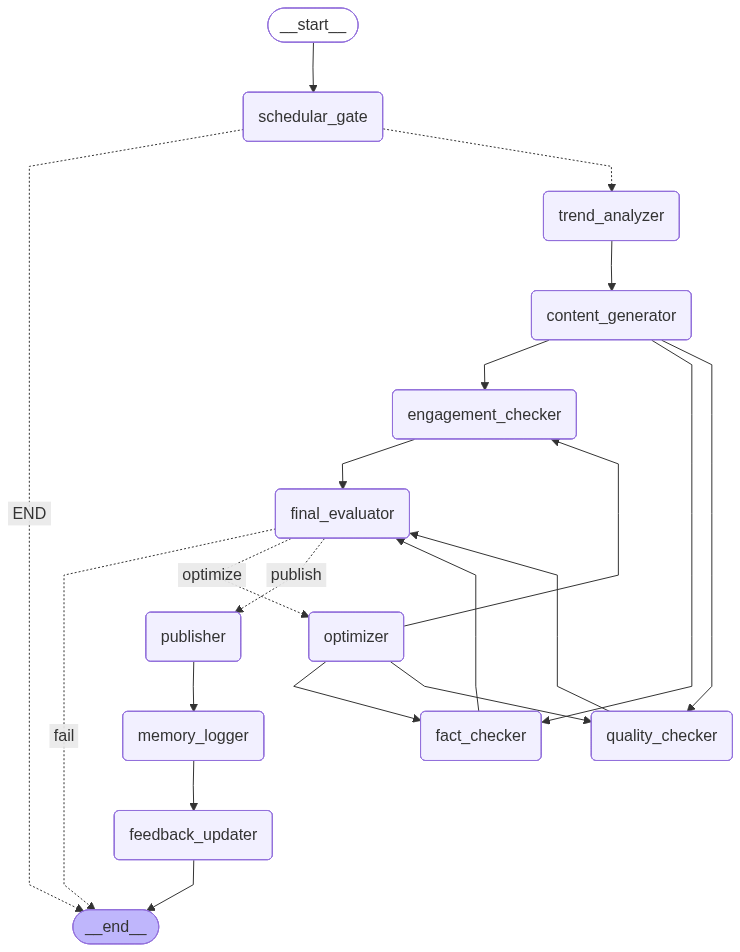

In [ ]:
# Now making the workflow
graph = StateGraph(AutoInfluenceState)

graph.add_node("trend_analyzer", trend_analyzer)
graph.add_node("content_generator", content_generator)

# Parallel worflow
graph.add_node("fact_checker", fact_checker)
graph.add_node("engagement_checker", engagement_checker)
graph.add_node("quality_checker", quality_checker)

graph.add_node("final_evaluator", final_evaluator) 

# Conditional
graph.add_node("optimizer", optimizer) 
graph.add_node("publisher", publisher) 

graph.add_node("memory_logger", memory_logger) 
graph.add_node("feedback_updater", feedback_updater)

# Schedular gate
graph.add_node("schedular_gate", scheduler_gate)

path_map = {
    "trend_analyzer" : "trend_analyzer",
    "END" : END
}

graph.add_conditional_edges("schedular_gate", scheduler_gate, path_map)

graph.set_entry_point("schedular_gate")
# --- Edges ---
graph.add_edge("trend_analyzer", "content_generator")

# Parallel evaluations
graph.add_edge("content_generator", "fact_checker")
graph.add_edge("content_generator", "quality_checker")
graph.add_edge("content_generator", "engagement_checker")

# Merge evaluations
graph.add_edge("fact_checker", "final_evaluator")
graph.add_edge("quality_checker", "final_evaluator")
graph.add_edge("engagement_checker", "final_evaluator")

path_map2 = {
    "publish": "publisher",    # if route_evaluation returns "publish"
    "optimize": "optimizer",     # if route_evaluation returns "optimize"
    "fail": END                  # if it returns "fail"
}

# Conditionals
graph.add_conditional_edges("final_evaluator", filter_drafts, path_map2)
graph.add_edge("optimizer", "fact_checker")
graph.add_edge("optimizer", "quality_checker")
graph.add_edge("optimizer", "engagement_checker")

# Publishing and logging
graph.add_edge("publisher", "memory_logger")
graph.add_edge("memory_logger", "feedback_updater")
graph.add_edge("feedback_updater", END)

# --- Compile ---
workflow = graph.compile()
workflow

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `route_evaluation` already exists for node `final_evaluator`

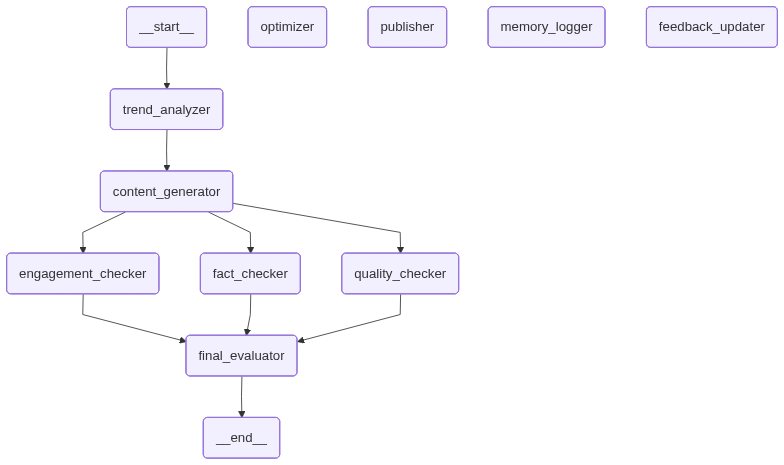

In [56]:
workflow = graph.compile()
workflow